In [ ]:
# @title Preparing Datasets for Corpus

import re
import os
import json
import requests
import pandas as pd

def download_data(url, file_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully!')
    else:
        print(f'Failed to download file. Status code: {response.status_code}')

# Data and File Paths
url = "https://raw.githubusercontent.com/Dr-Hutchinson/nicolay/main/data/lincoln_speech_corpus.json"
data_dir = "/content/"
file_name = "lincoln_speech_corpus.json"
file_path = os.path.join(data_dir, file_name)

# Downloading Lincoln speech corpus
download_data(url, file_path)

# Reading and displaying the first entry in the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Displaying the first entry
if data:
    first_entry = data[0]
    print("First entry in the JSON file:")
    print(json.dumps(first_entry, indent=4))
else:
    print("The JSON file is empty or not properly formatted.")


File downloaded successfully!
First entry in the JSON file:
{
    "text_id": "Text #: 0",
    "source": "Source:  At Peoria, Illinois. October 16, 1854.",
    "full_text": "\"The repeal of the Missouri Compromise, and the propriety of its restoration, constitute the subject of what I am about to say.\n\nAs I desire to present my own connected view of this subject, my remarks will not be, specifically, an answer to Judge Douglas; yet, as I proceed, the main points he has presented will arise, and will receive such respectful attention as I may be able to give them.\n\nI wish further to say, that I do not propose to question the patriotism, or to assail the motives of any man, or class of men; but rather to strictly confine myself to the naked merits of the question.\n\nI also wish to be no less than National in all the positions I may take; and whenever I take ground which others have thought, or may think, narrow, sectional and dangerous to the Union, I hope to give a reason, which wil

In [ ]:
# @title Common RAG Search Methods - installing dependencies

# Install the packages needing specific versions to avoid conflicts
!pip install -U pyarrow==14.0.2 requests==2.31.0 packaging==24.1

# Then install the rest of the dependencies
!pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube
!pip install jq
!pip install -U ragatouille
!pip install -U FlagEmbedding
!pip install -U transformers
!pip install qdrant-client>=1.1.1
!pip install -U sentence-transformers
!pip install nltk
!pip install ctransformers>=0.2.27
!pip install -q -U accelerate
!pip install -q -U bitsandbytes
!pip install secure-smtplib
!pip install rank-bm25
!pip install rouge-score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# @title Common RAG Search Methods - setting HuggingFace API key
from huggingface_hub import login

# Set you API key here
hf_token = "hf_"

# Login to Hugging Face
login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# @title Keyword Search (with BM25)

# Import necessary libraries for BM25, text processing, and data loading
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from langchain_community.document_loaders import JSONLoader

# Initialize Sentence Transformer Encoder for potential later use
encoder_name = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(encoder_name)

# Download necessary NLTK resources for text tokenization and stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words (common words that are usually filtered out in searches)
stop_words = set(stopwords.words('english'))

# Function to extract metadata from each document for BM25 indexing
def extract_metadata_for_bm25(record, metadata=None):
    if metadata is None:
        metadata = {}
    text_id = record.get("text_id", "N/A")  # Extract text ID
    full_text = record.get('full_text', "N/A")  # Extract full text of the document
    summary = record.get("summary", "N/A")  # Extract summary
    keywords = record.get("keywords", "N/A").replace("Keywords: ", "").split(", ")  # Extract and process keywords

    # Combine full text, summary, and keywords for BM25 indexing
    combined_text = f"{full_text} {summary} {' '.join(keywords)}"
    metadata.update({
        "Document ID": text_id,
        "full_text": combined_text,
        "source": record.get("source", "N/A"),  # Extract source information
        "summary": summary,
        "keywords": keywords
    })
    return metadata

# Function to load documents from a JSON file and preprocess them for BM25 indexing
def load_and_encode_documents_bm25(file_path):
    # Load documents using JSONLoader
    loader = JSONLoader(file_path, jq_schema='.[]', content_key="full_text", metadata_func=extract_metadata_for_bm25)
    docs = loader.load()
    bm25_texts = [doc.metadata['full_text'] for doc in docs]  # Extract full texts for BM25 processing

    # Preprocess text by tokenizing, converting to lowercase, and removing stop words
    def preprocess(text):
        tokens = word_tokenize(text.lower())
        return [token for token in tokens if token not in stop_words]

    # Initialize BM25 with preprocessed texts
    bm25 = BM25Okapi([preprocess(text) for text in bm25_texts])
    return docs, bm25

# Load and encode documents for BM25 keyword search
docs_bm25, bm25 = load_and_encode_documents_bm25(file_path)

# Function to perform a BM25 keyword search on the document corpus
def keyword_search_bm25(bm25, query, docs, encoder, limit):
    # Preprocess query by tokenizing and filtering out stop words
    tokenized_query = word_tokenize(query.lower())
    filtered_query = [word for word in tokenized_query if word not in stop_words]

    # Get BM25 scores for each document based on the query
    bm25_scores = bm25.get_scores(filtered_query)
    sorted_indices = sorted(range(len(bm25_scores)), key=lambda i: -bm25_scores[i])

    results = []

    # Collect top matching documents based on BM25 scores
    for idx in sorted_indices[:limit]:
        doc = docs[idx]
        key_quote = find_best_key_quote(doc.metadata['full_text'], query)  # Find best matching quote in the document
        results.append({
            'Query': query,
            'Document ID': doc.metadata['Document ID'],
            'Key Quote': key_quote,
            'Source': doc.metadata.get('source', 'N/A'),
            'Summary': doc.metadata.get('summary', 'N/A'),
            'Keywords': ', '.join(doc.metadata.get('keywords', [])),
            'BM25 Score': bm25_scores[idx],
            'Model': 'BM25'
        })

    return pd.DataFrame(results)

# Function to find the best matching quote in a document based on the query
def find_best_key_quote(full_text, query):
    query_terms = set([word.lower() for word in word_tokenize(query) if word not in stop_words])

    # Find all matches of the query terms in the full text
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(term) for term in query_terms) + r')\b', re.IGNORECASE)
    matches = [(m.start(), m.end()) for m in pattern.finditer(full_text)]

    if not matches:
        return full_text[:500]  # Fallback to the first 500 characters if no matches are found

    # Split text into sentences
    sentences = sent_tokenize(full_text)
    sentence_indices = [i for i, sentence in enumerate(sentences) if pattern.search(sentence)]

    if not sentence_indices:
        return full_text[:500]  # Fallback to the first 500 characters if no matching sentence is found

    best_index = sentence_indices[0]

    # Select two sentences before and after the matched sentence
    start_index = max(best_index - 2, 0)
    end_index = min(best_index + 3, len(sentences))

    best_window = ' '.join(sentences[start_index:end_index])

    return best_window

# Encoding Lincoln corpus and metadata for keyword search with BM25
docs_bm25, bm25 = load_and_encode_documents_bm25(file_path)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# @title Keyword Search: Set Query

query = "How did Lincoln regard Japan?"

In [ ]:
# @title Keyword Search: Corpus Search & Results

from IPython.display import display, HTML

# Function to highlight specific keywords in text
def highlight_keywords(text, keywords):
    escaped_keywords = [re.escape(keyword.strip()) for keyword in keywords]
    highlighted_text = text

    for keyword in escaped_keywords:
        keyword_pattern = re.compile(r'\b' + keyword + r'\b', re.IGNORECASE)
        highlighted_text = keyword_pattern.sub(r'<mark>\g<0></mark>', highlighted_text)

    return highlighted_text

bm25_results_df = keyword_search_bm25(bm25, query, docs_bm25, encoder, limit=5)


# Define the keywords to highlight
keywords_to_highlight = ["Lincoln", "regard", "Japan"]

# Apply the highlight_keywords function to Key Quote and Summary columns
bm25_results_df['Key Quote'] = bm25_results_df['Key Quote'].apply(lambda x: highlight_keywords(x, keywords_to_highlight))
bm25_results_df['Summary'] = bm25_results_df['Summary'].apply(lambda x: highlight_keywords(x, keywords_to_highlight))

# Apply the highlight_keywords function to the Keywords column with the same specified keywords
bm25_results_df['Keywords'] = bm25_results_df['Keywords'].apply(lambda x: highlight_keywords(x, keywords_to_highlight))

# Display the final DataFrame as HTML
bm25_results_html = bm25_results_df.head().to_html(escape=False)
display(HTML(bm25_results_html))

,Query,Document ID,Key Quote,Source,Summary,Keywords,BM25 Score,Model
0,How did Lincoln regard Japan?,Text #: 72,"The judicial consular establishment there has become very difficult and onerous, and it will need legislative revision to adapt it to the extension of our commerce, and to the more intimate intercourse which has been instituted with the government and people of that vast empire. China seems to be accepting with hearty good-will the conventional laws which regulate commercial and social intercourse among the western nations. Owing to the peculiar situation of Japan, and the anomalous form of its government, the action of that empire in performing treaty stipulations is inconstant and capricious. Nevertheless, good progress has been effected by the western powers, moving with enlightened concert. Our own pecuniary claims have been allowed, or put in course of settlement, and the inland sea has been reopened to commerce.","Source: Fourth Annual Message. December 6, 1864.","Summary: In Abraham Lincoln's Fourth Annual Message, he expresses gratitude for good health and abundant harvests. He discusses the United States' foreign relations, including maintaining neutrality in Mexico's civil war and involvement in various projects such as a river survey in Central America and the overland telegraph between America and Europe. He mentions the friendly relations with South American states, the ongoing civil war in the Spanish part of San Domingo, and the improvement in relations with Liberia. Lincoln also discusses the situation in China, where rebellion has been suppressed, and Japan, where progress has been made in performing treaty stipulations.","Fourth Annual Message, December 6, 1864, Abraham Lincoln, foreign relations, Mexico, civil war, Central America, river survey, overland telegraph, South American states, San Domingo, Liberia, China, Japan, treaty stipulations.",6.996904,BM25
1,How did Lincoln regard Japan?,Text #: 66,"""In common with other western powers, our relations with Japan have been brought into serious jeopardy, through the perverse opposition of the hereditary aristocracy of the empire, to the enlightened and liberal policy of the Tycoon designed to bring the country into the society of nations. It is hoped, although not with entire confidence, that these difficulties may be peacefully overcome. I ask your attention to the claim of the Minister residing there for the damages he sustained in the destruction by fire of the residence of the legation at Yedo.","Source: Third Annual Message. December 8, 1863.","Summary: In his Third Annual Message, President Abraham Lincoln discusses issues with Japan, improvements in the consular system, and the importance of international telegraph connections. He expresses satisfaction with the condition of organized Territories and the mineral resources they hold. He highlights the need for a system to encourage immigration and addresses the potential need for a special court to handle claims arising from injuries to foreign citizens. The President also mentions the taxation of foreign consuls' incomes and the successful operations of the Treasury, including the national banking law.","Third Annual Message, December 8, 1863, Abraham Lincoln, Japan, consular system, international telegraph, Atlantic ocean, organized Territories, mineral resources, immigration, foreign citizens, special court, taxation, foreign consuls, Treasury, national banking law.",6.767199,BM25
2,How did Lincoln regard Japan?,Text #: 58,"A considerable improvement of the national commerce is expected to result from these measures. Our relations with Great Britain, France, Spain, Portugal, Russia, Prussia, Denmark, Sweden, Austria, the Netherlands, Italy, Rome, and the other European states, remain undisturbed. Very favorable relations also continue to be maintained with Turkey, Morocco, China and Japan. During the last year there has not only been no change of our previous relations with the independe

In [ ]:
# @title Semantic Search (with Qdrant) - download model and encode corpus
from qdrant_client import QdrantClient, models
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import pandas as pd
import re

# Parameters
collection_name = "lincoln_speeches"  # Name of the collection in Qdrant
encoder_name = "all-MiniLM-L6-v2"  # Name of the sentence transformer model
limit = 10  # Number of results to return

# Initialize Sentence Transformer Encoder
encoder = SentenceTransformer(encoder_name)

# Define custom stopwords including 'Lincoln'
custom_stopwords = set(stopwords.words('english')).union({"lincoln"})

# Function to preprocess the query by tokenizing and removing stopwords
def preprocess_query(query):
    """
    Preprocess the query by tokenizing, converting to lowercase, and removing stopwords.

    Args:
    query (str): The input query string.

    Returns:
    str: The preprocessed query.
    """
    tokens = word_tokenize(query.lower())
    filtered_tokens = [word for word in tokens if word not in custom_stopwords]
    return " ".join(filtered_tokens)

# Function to extract metadata from each document for Qdrant indexing
def extract_metadata_for_qdrant(record, metadata=None):
    """
    Extract metadata from a document for Qdrant indexing.

    Args:
    record (dict): The document record.
    metadata (dict, optional): An existing metadata dictionary to update. Defaults to None.

    Returns:
    dict: The updated metadata dictionary.
    """
    if metadata is None:
        metadata = {}
    text_id = record.get("text_id", "N/A")
    full_text = record.get("full_text", "N/A")
    source = record.get("source", "N/A")
    summary = record.get("summary", "N/A")
    keywords = record.get("keywords", "").replace("Keywords: ", "").split(", ")

    combined_text = f"{full_text} {' '.join(keywords)}"

    metadata.update({
        "Document ID": text_id,
        "combined_text": combined_text,
        "full_text": full_text,
        "source": source,
        "summary": summary,
        "keywords": keywords
    })

    return metadata

# Function to load and encode documents for Qdrant
def load_and_encode_documents_qdrant(file_path, collection_name, encoder_name):
    """
    Load documents from a JSON file, encode them using a sentence transformer, and upload to Qdrant.

    Args:
    file_path (str): Path to the JSON file containing the documents.
    collection_name (str): Name of the Qdrant collection.
    encoder_name (str): Name of the sentence transformer model.

    Returns:
    tuple: A tuple containing the list of documents and the Qdrant client instance.
    """
    encoder = SentenceTransformer(encoder_name)
    loader = JSONLoader(file_path, jq_schema='.[]', content_key="full_text", metadata_func=extract_metadata_for_qdrant)
    docs = loader.load()

    # Initialize Qdrant client with in-memory storage
    qdrant_client = QdrantClient(":memory:")
    qdrant_client.recreate_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
            size=encoder.get_sentence_embedding_dimension(),
            distance=models.Distance.COSINE
        )
    )

    # Prepare records for Qdrant
    records = [
        models.Record(
            id=idx,
            vector=encoder.encode(doc.metadata['combined_text']).tolist(),
            payload=doc.metadata
        ) for idx, doc in enumerate(docs)
    ]

    # Upload records to Qdrant
    qdrant_client.upload_records(collection_name=collection_name, records=records)

    return docs, qdrant_client

def vector_search_qdrant_with_similar_words(qdrant_client, collection_name, query_vector, query, limit):
    """
    Perform vector search with Qdrant and find similar words in the relevant sentences.

    Args:
    qdrant_client (QdrantClient): The Qdrant client instance.
    collection_name (str): Name of the Qdrant collection.
    query_vector (list): The query vector.
    query (str): The original query string.
    limit (int): Number of results to return.

    Returns:
    pd.DataFrame: DataFrame containing search results with additional metadata.
    """
    # Perform a vector search in Qdrant
    hits = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_vector.tolist(),
        limit=limit
    )

    results_df = pd.DataFrame(columns=[
        'Query', 'Document ID', 'Key Quote', 'Source', 'Summary', 'Keywords',
        'Semantic Score', 'Similar Words', 'Model'
    ])

    for hit in hits:
        full_text = hit.payload["full_text"]
        text_id = hit.payload["Document ID"]
        source = hit.payload.get("source", "N/A")
        summary = hit.payload.get("summary", "N/A")
        keywords = hit.payload.get("keywords", "")

        # Split the full text into sentences
        sentences = sent_tokenize(full_text)

        # Encode each sentence using the sentence transformer model
        sentence_embeddings = encoder.encode(sentences)

        # Calculate cosine similarity between the query vector and each sentence vector
        sentence_similarities = [1 - cosine(query_vector, sent_vec.tolist()) for sent_vec in sentence_embeddings]

        # Identify the index of the highest scoring sentence (most similar to the query)
        highest_scoring_sentence_idx = sentence_similarities.index(max(sentence_similarities))

        # Determine the number of sentences to include around the highest scoring sentence
        num_sentences_around = 3  # Number of sentences to include before and after the best match

        # Calculate the start and end indices for the sentences to include
        start_sentence_idx = max(0, highest_scoring_sentence_idx - num_sentences_around)
        end_sentence_idx = min(len(sentences), highest_scoring_sentence_idx + num_sentences_around + 1)

        # Extract the relevant sentences around the highest scoring sentence
        relevant_sentences = " ".join(sentences[start_sentence_idx:end_sentence_idx])

        # Extract words from the relevant sentences
        words = set(word_tokenize(relevant_sentences.lower()))

        # Encode each word in the relevant sentences
        word_embeddings = {word: encoder.encode([word])[0] for word in words}

        # Encode the query
        query_embedding = encoder.encode([query])[0]

        # Compute similarity between the query embedding and each word embedding
        similar_words = compute_similarity(word_embeddings, query_embedding)

        # Get the top 5 similar words with their similarity scores
        top_similar_words = similar_words[:5]

        new_row = {
            "Query": query,
            "Document ID": text_id,
            "Key Quote": relevant_sentences,
            "Source": source,
            "Summary": summary,
            "Keywords": ", ".join(keywords),
            "Semantic Score": max(sentence_similarities),
            "Similar Words": [(word, round(score, 4)) for word, score in top_similar_words],
            "Model": "Qdrant"
        }

        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

    # Sort results by Semantic Score in descending order
    results_df.sort_values(by='Semantic Score', ascending=False, inplace=True)
    results_df.reset_index(drop=True, inplace=True)

    return results_df


# Function to compute similarity between word embeddings and query embedding
def compute_similarity(word_embeddings, query_embedding):
    """
    Compute similarity between word embeddings and query embedding.

    Args:
    word_embeddings (dict): Dictionary of word embeddings.
    query_embedding (list): The query embedding.

    Returns:
    list: List of tuples containing words and their similarity scores, sorted by similarity.
    """
    similarities = []
    for word, embedding in word_embeddings.items():
        similarity = 1 - cosine(query_embedding, embedding)
        similarities.append((word, similarity))
    return sorted(similarities, key=lambda x: -x[1])

# Load and encode documents for Qdrant
docs_qdrant, qdrant_client = load_and_encode_documents_qdrant(file_path, collection_name, encoder_name)


<ipython-input-7-3289dc99c121>:89: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(
<ipython-input-7-3289dc99c121>:107: DeprecationWarning: `upload_records` is deprecated, use `upload_points` instead
  qdrant_client.upload_records(collection_name=collection_name, records=records)


In [ ]:
# @title Semantic Search: Set Query

query = "How did Lincoln use religious imagery?"

In [ ]:
# @title Semantic Search: Corpus Search & Results

# Functions for highlighting results

# Highlight Similar Words Function
def highlight_similar_words(text, similar_words):
    if not isinstance(text, str):
        return text  # If the input is not a string, return it as-is

    highlighted_text = text
    for word, similarity in similar_words:
        escaped_word = re.escape(word.strip())
        color = get_color(similarity)
        word_pattern = re.compile(r'\b' + escaped_word + r'\b', re.IGNORECASE)
        highlighted_text = word_pattern.sub(fr'<mark style="background-color: {color};">\g<0></mark>', highlighted_text)

    return highlighted_text


# Apply Highlighting Function
def apply_highlighting(df):
    if 'Key Quote' in df.columns and 'Similar Words' in df.columns:
        df['Key Quote'] = df.apply(lambda x: highlight_similar_words(x['Key Quote'], x['Similar Words']), axis=1)
    return df

def get_color(similarity):
    """Returns a color code based on the similarity score."""
    if similarity > 0.3:
        return '#F88379'  # Coral
    elif similarity > 0.25:
        return '#FA5F55'  # Orange Red
    elif similarity > 0.2:
        return '#ff7f00'  # Orange
    elif similarity > 0.15:
        return '#ffbf00'  # Amber
    else:
        return '#ffff00'  # Yellow


# Preprocess and encode the query to drop custom stopwords
preprocessed_query = preprocess_query(query)
query_vector = encoder.encode(preprocessed_query)

# Perform Qdrant search with similar words
qdrant_results_df = vector_search_qdrant_with_similar_words(qdrant_client, collection_name, query_vector, query, limit)

# Apply highlighting
qdrant_results_df = apply_highlighting(qdrant_results_df)

# Display the final DataFrame as HTML
qdrant_results_html = qdrant_results_df.head().to_html(escape=False)
display(HTML(qdrant_results_html))


,Query,Document ID,Key Quote,Source,Summary,Keywords,Semantic Score,Similar Words,Model
0,How did Lincoln use religious imagery?,Text #: 79,"Both read the same Bible, and pray to the same God; and each invokes His aid against the other. It may seem strange that any men should dare to ask a just God's assistance in wringing their bread from the sweat of other men's faces; but let us judge not that we be not judged. The prayers of both could not be answered; that of neither has been answered fully. The Almighty has His own purposes. ``Woe unto the world because of offences! for it must needs be that offences come; but woe to that man by whom the offence cometh!'' If we shall suppose that American Slavery is one of those offences which, in the providence of God, must needs come, but which, having continued through His appointed time, He now wills to remove, and that He gives to both North and South, this terrible war, as the woe due to those by whom the offence came, shall we discern therein any departure from those divine attributes which the believers in a Living God always ascribe to Him?","Source: Second Inaugural Address. March 4, 1865.","Summary: In his Second Inaugural Address, Abraham Lincoln reflects on the Civil War and the role of slavery in causing the conflict. He acknowledges the unexpected magnitude and duration of the war, and considers the possibility that it might be divine punishment for the offense of slavery. Despite the ongoing war, Lincoln urges the nation to continue with malice toward none and charity for all, and to work toward binding up the nation's wounds and achieving a lasting peace.","Second Inaugural Address, March 4, 1865, Abraham Lincoln, Civil War, slavery, divine judgment, magnitude, duration, malice, charity, healing, lasting peace.",0.407594,"[(slavery, 0.3058), (prayers, 0.2878), (believers, 0.2873), (bible, 0.2752), (south, 0.206)]",Qdrant
1,How did Lincoln use religious imagery?,Text #: 14,"""But NOW it is to be transformed into a sacred right.'' Nebraska brings it forth, places it on the high road to extension and perpetuity; and, with a pat on its back, says to it, Go, and God speed you.'' Henceforth it is to be the chief jewel of the nation---the very figure-head of the ship of State. Little by little, but steadily as man's march to the grave, we have been giving up the OLD for the NEW faith.","Source: At Peoria, Illinois. October 16, 1854.","Summary: In this excerpt, Abraham Lincoln criticizes the transformation of slavery into a ""sacred right"" and asserts that the principles of the Declaration of Independence and the Nebraska bill are incompatible. He calls for Americans to recognize the dangers of abandoning their founding principles and the potential harm to liberty. Lincoln advocates for returning to the principles and policies of the Declaration of Independence and saving the Union in a way that upholds its values. He also addresses Stephen Douglas's response to his previous speech, maintaining that the world will continue to believe that the Nebraska bill was intended to extend slavery.","Abraham Lincoln, Nebraska bill, slavery, Declaration of Independence, liberty, founding principles, Judge Douglas, Union, progress, antagonisms, moral right, legal rights, necessity, American values.",0.378523,"[(sacred, 0.3082), (faith, 0.2996), (nebraska, 0.2857), (figure-head, 0.1959), (god, 0.1914)]",Qdrant
2,How did Lincoln use religious imagery?,Text #: 55,"If you are, you should say so plainly. If you are not for force, nor yet for dissolution, there only remains some imaginable compromise. I do not believe any compromise, embracing the maintenance of the Union, is now possible. All I learn, leads to a directly opposite belief. The strength of the rebellion, is its military---its army. That army dominates all the country, and all the people, within its range. Any offer of terms made by any man or men within that range, in opposition to that army, is simply nothing for the present; beca

In [ ]:
# @title Contextual Search (with ColBERT) - download model & load data

# Import necessary libraries
from ragatouille import RAGPretrainedModel
from langchain_community.document_loaders import JSONLoader
from sentence_transformers import SentenceTransformer
import pandas as pd
import re


# Set parameters for ColBERT and the encoder
k = 10
index_name = "LincolnCorpus_1"
encoder_name = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(encoder_name)

# Function to extract metadata from documents
def extract_metadata_for_colbert(record, metadata=None):
    """Extracts and combines metadata from a record for indexing."""
    if metadata is None:
        metadata = {}
    text_id = record.get("text_id", "N/A")
    full_text = record.get("full_text", "N/A")
    source = record.get("source", "N/A")
    summary = record.get("summary", "N/A")
    keywords = record.get("keywords", "N/A")
    keywords = keywords.replace("Keywords: ", "").split(", ")

    combined_text = f"{full_text} {summary} {' '.join(keywords)}"
    metadata.update({
        "Document ID": text_id,
        "full_text": full_text,
        "source": source,
        "summary": summary,
        "keywords": keywords,
        "combined_text": combined_text
    })
    return metadata

# Function to setup RAGatouille model and index documents
def setup_ragatouille(document_ids, document_texts, index_name, base_index_dir=".ragatouille/colbert/indexes"):
    """Sets up the RAGatouille model and indexes documents. If an index exists, loads it; otherwise, creates a new one."""
    path_to_index = os.path.join(base_index_dir, index_name)
    if os.path.exists(path_to_index):
        print(f"Loading existing RAGatouille index from: {path_to_index}")
        rag_model = RAGPretrainedModel.from_index(path_to_index)
    else:
        print(f"Creating new RAGatouille index at: {path_to_index}")
        os.makedirs(path_to_index, exist_ok=True)
        rag_model = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
        rag_model.index(
            collection=document_texts,
            document_ids=document_ids,
            index_name=index_name,
            max_document_length=90,
            split_documents=True
        )
    return rag_model, path_to_index

# Function to load and encode documents for ColBERT
def load_and_encode_documents_colbert(file_path):
    """Loads documents and encodes them using a sentence transformer model."""
    loader = JSONLoader(file_path, jq_schema='.[]', content_key="full_text", metadata_func=extract_metadata_for_colbert)
    docs = loader.load()
    document_ids = [doc.metadata['Document ID'] for doc in docs]
    document_texts = [doc.metadata['full_text'] for doc in docs]
    return docs, document_ids, document_texts

# Function to find the best matching quote and compute similarity scores
def find_best_key_quote_with_scores(full_text, query, encoder):
    """Finds the best matching quote in the text and computes similarity scores."""
    query_vector = encoder.encode([query])[0]
    sentences = sent_tokenize(full_text)
    sentence_embeddings = encoder.encode(sentences)
    sentence_similarities = [1 - cosine(query_vector, sent_vec) for sent_vec in sentence_embeddings]
    highest_scoring_sentence_idx = sentence_similarities.index(max(sentence_similarities))

    num_sentences_around = 3
    start_sentence_idx = max(0, highest_scoring_sentence_idx - num_sentences_around)
    end_sentence_idx = min(len(sentences), highest_scoring_sentence_idx + num_sentences_around + 1)
    best_window = ' '.join(sentences[start_sentence_idx:end_sentence_idx])

    return best_window, sentence_similarities, sentences

# Function to perform ColBERT search and score results
def rag_search_with_scores(rag_model, original_query, preprocessed_query, metadata_mapping, encoder, k=5):
    """Performs a ColBERT search and scores the results."""
    results = rag_model.search(query=preprocessed_query, k=k)
    seen_docs = set()
    augmented_results = []

    for result in results:
        doc_id = result['document_id']
        if doc_id in seen_docs:
            continue
        seen_docs.add(doc_id)

        metadata = metadata_mapping.get(doc_id, {})
        full_text = metadata.get('full_text', 'N/A')
        key_quote, sentence_similarities, sentences = find_best_key_quote_with_scores(full_text, preprocessed_query, encoder)

        augmented_result = {
            'Query': original_query,
            'Document ID': doc_id,
            'Key Quote': key_quote,
            'Source': metadata.get('source', 'N/A'),
            'Summary': metadata.get('summary', 'N/A'),
            'Keywords': metadata.get('keywords', 'N/A'),
            'ColBERT Score': result['score'],
            'Model': 'ColBERT',
            'Sentence Similarities': sentence_similarities,
            'Sentences': sentences
        }
        augmented_results.append(augmented_result)

    results_df = pd.DataFrame(augmented_results)
    return results_df

# Main Execution - Integrate ColBERT Search with Relevant Passage Extraction
docs_colbert, document_ids, document_texts = load_and_encode_documents_colbert(file_path)
metadata_mapping = {doc.metadata['Document ID']: doc.metadata for doc in docs_colbert}

rag_model, _ = setup_ragatouille(document_ids, document_texts, index_name)

Creating new RAGatouille index at: .ragatouille/colbert/indexes/LincolnCorpus_1


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Jul 13, 15:19:45] #> Note: Output directory .ragatouille/colbert/indexes/LincolnCorpus_1 already exists


[Jul 13, 15:19:48] [0] 		 #> Encoding 1389 passages..
[Jul 13, 15:19:50] [0] 		 avg_doclen_est = 64.28653717041016 	 len(local_sample) = 1,389
[Jul 13, 15:19:50] [0] 		 Creating 4,096 partitions.
[Jul 13, 15:19:50] [0] 		 *Estimated* 89,294 embeddings.
[Jul 13, 15:19:50] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/LincolnCorpus_1/plan.json ..
used 20 iterations (2.0972s) to cluster 84830 items into 4096 clusters
[J

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[Jul 13, 15:21:33] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[0.038, 0.04, 0.043, 0.039, 0.04, 0.041, 0.039, 0.037, 0.038, 0.041, 0.037, 0.041, 0.039, 0.042, 0.039, 0.042, 0.035, 0.036, 0.038, 0.038, 0.04, 0.043, 0.038, 0.039, 0.036, 0.038, 0.042, 0.039, 0.04, 0.039, 0.041, 0.04, 0.042, 0.037, 0.039, 0.035, 0.039, 0.04, 0.039, 0.047, 0.041, 0.037, 0.04, 0.04, 0.039, 0.038, 0.038, 0.045, 0.042, 0.038, 0.039, 0.039, 0.041, 0.039, 0.038, 0.038, 0.045, 0.042, 0.046, 0.039, 0.037, 0.041, 0.04, 0.042, 0.041, 0.041, 0.042, 0.039, 0.035, 0.038, 0.042, 0.037, 0.039, 0.042, 0.039, 0.04, 0.041, 0.043, 0.04, 0.041, 0.041, 0.04, 0.04, 0.04, 0.041, 0.038, 0.04, 0.039, 0.039, 0.046, 0.04, 0.042, 0.04, 0.039, 0.039, 0.041, 0.045, 0.038, 0.038, 0.042, 0.041, 0.041, 0.041, 0.039, 0.041, 0.04, 0.037, 0.038, 0.039, 0.037, 0.038, 0.041, 0.041, 0.038, 0.041, 0.041, 0.038, 0.043, 0.042, 0.04, 0.038, 0.038, 0.038, 0.041, 0.038, 0.04, 0.04, 0.038]


0it [00:00, ?it/s]

[Jul 13, 15:23:29] [0] 		 #> Encoding 1389 passages..


1it [00:02,  2.36s/it]
100%|██████████| 1/1 [00:00<00:00, 363.27it/s]

[Jul 13, 15:23:32] #> Optimizing IVF to store map from centroids to list of pids..
[Jul 13, 15:23:32] #> Building the emb2pid mapping..
[Jul 13, 15:23:32] len(emb2pid) = 89294



100%|██████████| 4096/4096 [00:00<00:00, 38358.97it/s]

[Jul 13, 15:23:32] #> Saved optimized IVF to .ragatouille/colbert/indexes/LincolnCorpus_1/ivf.pid.pt


Done indexing!


In [ ]:
# @title Contextual Search: Set Query

query = "How did Lincoln regard democracy as a form of government?"

In [ ]:
# @title Contextual Search: Corpus Search & Results

def highlight_highest_scoring_sentence(text, sentences, similarities):
    max_similarity = max(similarities)
    highest_scoring_sentence = sentences[similarities.index(max_similarity)]
    highlighted_text = text.replace(highest_scoring_sentence, f'<mark style="background-color: #F88379;">{highest_scoring_sentence}</mark>')
    return highlighted_text

def apply_highlighting_colbert(df):
    if 'Key Quote' in df.columns and 'Sentence Similarities' in df.columns and 'Sentences' in df.columns:
        df['Key Quote'] = df.apply(lambda x: highlight_highest_scoring_sentence(x['Key Quote'], x['Sentences'], x['Sentence Similarities']), axis=1)
    return df.drop(columns=['Sentence Similarities', 'Sentences'])  # Remove extra columns

query = "How did Lincoln regard democracy as a form of government?"

# Preprocess and encode the query
preprocessed_query = preprocess_query(query)

# Perform ColBERT search
colbert_results_df = rag_search_with_scores(rag_model, query, preprocessed_query, metadata_mapping, encoder, k=limit)


# Apply highlighting and display results
colbert_results_df = apply_highlighting_colbert(colbert_results_df)
colbert_results_html = colbert_results_df.head().to_html(escape=False)
display(HTML(colbert_results_html))

Loading searcher for index LincolnCorpus_1 for the first time... This may take a few seconds
[Jul 13, 15:23:35] #> Loading codec...
[Jul 13, 15:23:35] #> Loading IVF...
[Jul 13, 15:23:35] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 867.67it/s]

[Jul 13, 15:23:35] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 142.11it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . regard democracy form government ?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 7634, 7072, 2433, 2231, 1029,  102,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



,Query,Document ID,Key Quote,Source,Summary,Keywords,ColBERT Score,Model
0,How did Lincoln regard democracy as a form of government?,Text #: 46,"Why this deliberate pressing out of view, the rights of men, and the authority of the people? This is essentially a People's contest. On the side of the Union, it is a struggle for maintaining in the world, that form, and substance of government, whose leading object is, to elevate the condition of men---to lift artificial weights from all shoulders---to clear the paths of laudable pursuit for all---to afford all, an unfettered start, and a fair chance, in the race of life. Yielding to partial, and temporary departures, from necessity, this is the leading object of the government for whose existence we contend. I am most happy to believe that the plain people understand, and appreciate this. It is worthy of note, that while in this, the government's hour of trial, large numbers of those in the Army and Navy, who have been favored with the offices, have resigned, and proved false to the hand which had pampered them, not one common soldier, or common sailor is is known to have deserted his flag. Great honor is due to those officers who remain true, despite the example of their treacherous associates; but the greatest honor, and most important fact of all, is the unanimous firmness of the common soldiers, and common sailors.","Source: July 4th Message to Congress. July 4, 1861.","Summary: In this excerpt from Abraham Lincoln's July 4 Message to Congress, he emphasizes the importance of preserving the Union and the exceptional nature of the nation's free institutions. He highlights the voluntary nature of the army and the loyalty of common soldiers in the face of rebellion. Lincoln argues that the government must be preserved for the benefit of all citizens and that the conflict is a test of whether the nation can survive internal threats. He assures that, once the rebellion is suppressed, his administration will continue to be guided by the Constitution and the laws. Lastly, he calls for trust in God and urges the nation to move forward without fear and with manly hearts.","[ Union, free institutions, army, rebellion, Constitution, loyalty, preservation, government, trust in God.]",14.210938,ColBERT
1,How did Lincoln regard democracy as a form of government?,Text #: 41,"Then, and thereby, the assailants of the Government, began the conflict of arms, without a gun in sight, or in expectancy, to return their fire, save only the few in the Fort, sent to that harbor, years before, for their own protection, and still ready to give that protection, in whatever was lawful. In this act, discarding all else, they have forced upon the country, the distinct issue: Immediate dissolution, or blood.'' And this issue embraces more than the fate of these United States. It presents to the whole family of man, the question, whether a constitutional republic, or a democracy---a government of the people, by the same people---can, or cannot, maintain its territorial integrity, against its own domestic foes. It presents the question, whether discontented individuals, too few in numbers to control administration, according to organic law, in any case, can always, upon the pretences made in this case, or on any other pretences, or arbitrarily, without any pretence, break up their Government, and thus practically put an end to free government upon the earth. It forces us to ask: Is there, in all republics, this inherent, and fatal weakness?'' ``Must a government, of necessity, be too strong for the liberties of its own people, or too weak to maintain its own existence?''","Source: July 4th Message to Congress. July 4, 1861.","Summary: In Abraham Lincoln's July 4 Message to Congress in 1861, he discusses the difficult decision-making process surrounding the events at Fort Sumter. Abandoning the fort was seen as ruinous, as it would discourage Union supporters, embolden adversaries, and potentially lead to foreign

In [ ]:
# @title Combined Search: Set Query

query = "How did Lincoln regard Japan?"

In [ ]:
# @title Combined Search of Corpus

# Initialize DataFrame to store all results
all_results = pd.DataFrame()

# Perform BM25 search
bm25_results_df = keyword_search_bm25(bm25, query, docs_bm25, encoder, limit=5)

# Perform Qdrant search
preprocessed_query = preprocess_query(query)
query_vector = encoder.encode(preprocessed_query)
qdrant_results_df = vector_search_qdrant_with_similar_words(qdrant_client, collection_name, query_vector, query, limit=5)

# Perform ColBERT search
colbert_results_df = rag_search_with_scores(rag_model, query, preprocessed_query, metadata_mapping, encoder, k=5)

# Combine results from all models
combined_results_df = pd.concat([bm25_results_df, qdrant_results_df, colbert_results_df], ignore_index=True)

# Display combined results for reference
#display(combined_results_df.head())

# Calculate and print the number of results for each search method
num_bm25_results = len(bm25_results_df)
num_qdrant_results = len(qdrant_results_df)
num_colbert_results = len(colbert_results_df)

print(f"Number of BM25 results: {num_bm25_results}")
print(f"Number of Qdrant results: {num_qdrant_results}")
print(f"Number of ColBERT results: {num_colbert_results}")

Number of BM25 results: 5
Number of Qdrant results: 5
Number of ColBERT results: 3


In [ ]:
# @title Reranking Search Results (with BGE-Base) - download model & reranking results

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline


# Reranker Model
reranker_model_name = "BAAI/bge-reranker-base"

def rerank_with_bge(combined_results_df, query, model_name):
    """Reranks results using the BGE reranker model."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.eval()

    pairs = [
        [
            query,
            f"{row['Key Quote']}"
        ]
        for index, row in combined_results_df.iterrows()
    ]

    with torch.no_grad():
        inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
        scores = model(**inputs, return_dict=True).logits.view(-1).float()

    combined_results_df['Reranking Score'] = scores.numpy()
    combined_results_df.sort_values(by='Reranking Score', ascending=False, inplace=True)
    combined_results_df.reset_index(drop=True, inplace=True)

    return combined_results_df

# Rerank combined results using BGE reranker
combined_results_df = rerank_with_bge(combined_results_df, query, reranker_model_name)

# Display reranked results for reference
display(combined_results_df.head())


tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

,Query,Document ID,Key Quote,Source,Summary,Keywords,BM25 Score,Model,Semantic Score,Similar Words,ColBERT Score,Sentence Similarities,Sentences,Reranking Score
0,How did Lincoln regard Japan?,Text #: 72,"Owing to the peculiar situation of Japan, and ...","Source: Fourth Annual Message. December 6, 1864.",Summary: In Abraham Lincoln's Fourth Annual Me...,"Fourth Annual Message, December 6, 1864, Abra...",NaN,Qdrant,0.549254,"[(japan, 0.4568), (treaty, 0.2366), (sea, 0.20...",NaN,NaN,NaN,-1.820833
1,How did Lincoln regard Japan?,Text #: 72,"Owing to the peculiar situation of Japan, and ...","Source: Fourth Annual Message. December 6, 1864.",Summary: In Abraham Lincoln's Fourth Annual Me...,"[ Fourth Annual Message, December 6, 1864, Abr...",NaN,ColBERT,NaN,NaN,17.781250,"[0.1224684864282608, 0.2740699350833893, 0.136...","[""Fellow-citizens of the Senate December 6, 18...",-1.820833
2,How did Lincoln regard Japan?,Text #: 58,A commercial and consular treaty has been nego...,"Source: Second Annual Message. December 1, 1862","Summary: In his Second Annual Message, Abraham...","[ Abraham Lincoln, Second Annual Message, Dece...",NaN,ColBERT,NaN,NaN,15.148438,"[0.09101738035678864, 0.05640604346990585, 0.1...","[""The new commercial treaty between the United...",-1.873236
3,How did Lincoln regard Japan?,Text #: 66,"""In common with other western powers, our rela...","Source: Third Annual Message. December 8, 1863.","Summary: In his Third Annual Message, Presiden...","Third Annual Message, December 8, 1863, Abrah...",6.767199,BM25,NaN,NaN,NaN,NaN,NaN,-4.058836
4,How did Lincoln regard Japan?,Text #: 58,A considerable improvement of the national com...,"Source: Second Annual Message. December 1, 1862","Summary: In his Second Annual Message, Abraham...","Abraham Lincoln, Second Annual Message, Decem...",6.423327,BM25,NaN,NaN,NaN,NaN,NaN,-4.425448


In [ ]:
# @title Deduplicate and Rank Results Using RRF Scoring

def deduplicate_and_rank(combined_results_df, k_parameter=50, base_value=0.03):
    """
    Deduplicates search results and calculates RRF (Reciprocal Rank Fusion) score for ranking.

    Parameters:
    combined_results_df (pd.DataFrame): DataFrame containing combined search results from various models.
    k_parameter (int): A constant parameter for RRF scoring. Default is 50.
    base_value (float): A base value to normalize RRF scores. Default is 0.03.

    Returns:
    pd.DataFrame: Deduplicated and ranked DataFrame based on RRF scores.
    """
    # Deduplicate results based on Document ID and sort by reranking score
    deduplicated_df = combined_results_df.sort_values('Reranking Score', ascending=False).drop_duplicates('Document ID').copy()

    # Calculate ranks for reranking, semantic, ColBERT, and BM25 scores
    deduplicated_df['reranking_rank'] = deduplicated_df['Reranking Score'].rank(ascending=False, method='min')
    deduplicated_df['semantic_rank'] = deduplicated_df['Semantic Score'].rank(ascending=False, method='min')
    deduplicated_df['colbert_rank'] = deduplicated_df['ColBERT Score'].rank(ascending=False, method='min')
    deduplicated_df['bm25_rank'] = deduplicated_df['BM25 Score'].rank(ascending=False, method='min')

    # Initialize RRF scores
    deduplicated_df['RRF'] = 0

    # Calculate RRF scores for Qdrant results
    qdrant_indices = deduplicated_df['Model'] == 'Qdrant'
    valid_qdrant_indices = qdrant_indices & deduplicated_df['semantic_rank'].notna() & deduplicated_df['reranking_rank'].notna()
    deduplicated_df.loc[valid_qdrant_indices, 'RRF'] = (
        1 / (k_parameter + deduplicated_df.loc[valid_qdrant_indices, 'semantic_rank']) +
        1 / (k_parameter + deduplicated_df.loc[valid_qdrant_indices, 'reranking_rank'])
    )

    # Calculate RRF scores for ColBERT results
    colbert_indices = deduplicated_df['Model'] == 'ColBERT'
    valid_colbert_indices = colbert_indices & deduplicated_df['colbert_rank'].notna() & deduplicated_df['reranking_rank'].notna()
    deduplicated_df.loc[valid_colbert_indices, 'RRF'] = (
        1 / (k_parameter + deduplicated_df.loc[valid_colbert_indices, 'colbert_rank']) +
        1 / (k_parameter + deduplicated_df.loc[valid_colbert_indices, 'reranking_rank'])
    )

    # Calculate RRF scores for BM25 results
    bm25_indices = deduplicated_df['Model'] == 'BM25'
    valid_bm25_indices = bm25_indices & deduplicated_df['bm25_rank'].notna() & deduplicated_df['reranking_rank'].notna()
    deduplicated_df.loc[valid_bm25_indices, 'RRF'] = (
        1 / (k_parameter + deduplicated_df.loc[valid_bm25_indices, 'bm25_rank']) +
        1 / (k_parameter + deduplicated_df.loc[valid_bm25_indices, 'reranking_rank'])
    )

    # Normalize and format RRF scores
    deduplicated_df['RRF'] = deduplicated_df['RRF'].apply(lambda x: round((x - base_value) * 10000))
    deduplicated_df['RRF'] = deduplicated_df['RRF'].apply(lambda x: f"{x}%" if x >= 0 else "0%")

    # Sort results by RRF scores in descending order
    deduplicated_df.sort_values(by='RRF', ascending=False, na_position='last', inplace=True)
    deduplicated_df.reset_index(drop=True, inplace=True)

    # Highlight the keyword "Japan" in the 'Key Quote' column
    keyword = "Japan"
    deduplicated_df['Key Quote'] = deduplicated_df['Key Quote'].apply(lambda x: highlight_keyword(x, keyword))

    return deduplicated_df

def highlight_keyword(text, keyword):
    """
    Highlights the specified keyword in the given text.

    Parameters:
    text (str): The input text where the keyword will be highlighted.
    keyword (str): The keyword to be highlighted.

    Returns:
    str: The text with the keyword highlighted.
    """
    highlighted_text = re.sub(rf'(\b{re.escape(keyword)}\b)', r'<mark>\1</mark>', text, flags=re.IGNORECASE)
    return highlighted_text


# Deduplicate and rank results using RRF scoring
final_results_df = deduplicate_and_rank(combined_results_df)

# Drop unwanted columns from the final DataFrame
final_results_df = final_results_df.drop(columns=['Similar Words', 'Sentences'], errors='ignore')

# Rearrange columns in the final DataFrame for better readability
column_order = ['Query', 'Document ID', 'Key Quote', 'Source', 'Summary', 'Keywords', 'Model', 'BM25 Score', 'bm25_rank', 'Semantic Score', 'semantic_rank', 'ColBERT Score', 'colbert_rank', 'Reranking Score', 'reranking_rank', 'RRF']
final_results_df = final_results_df[column_order]

# Save final results to a CSV file
filename = 'final_aggregated_results_with_bge.csv'
filepath = f'/content/{filename}'
final_results_df.to_csv(filepath, index=False)

# Highlight the keyword "Japan" in the 'Key Quote', 'Summary', and 'Keywords' columns
keyword = "Japan"

final_results_df['Key Quote'] = final_results_df['Key Quote'].apply(lambda x: highlight_keyword(x, keyword))
final_results_df['Summary'] = final_results_df['Summary'].apply(lambda x: highlight_keyword(x, keyword))
final_results_df['Keywords'] = final_results_df['Keywords'].apply(lambda x: highlight_keyword(', '.join(x) if isinstance(x, list) else x, keyword))


# Display the final DataFrame as HTML
final_results_df_html = final_results_df.head().to_html(escape=False)
display(HTML(final_results_df_html))

# Display a message indicating that the results are saved
print(f"Final results saved to {filepath}")


,Query,Document ID,Key Quote,Source,Summary,Keywords,Model,BM25 Score,bm25_rank,Semantic Score,semantic_rank,ColBERT Score,colbert_rank,Reranking Score,reranking_rank,RRF
0,How did Lincoln regard Japan?,Text #: 72,"Owing to the peculiar situation of Japan, and the anomalous form of its government, the action of that empire in performing treaty stipulations is inconstant and capricious. Nevertheless, good progress has been effected by the western powers, moving with enlightened concert. Our own pecuniary claims have been allowed, or put in course of settlement, and the inland sea has been reopened to commerce. There is reason also to believe that these proceedings have increased rather than diminished the friendship of Japan towards the United States.""","Source: Fourth Annual Message. December 6, 1864.","Summary: In Abraham Lincoln's Fourth Annual Message, he expresses gratitude for good health and abundant harvests. He discusses the United States' foreign relations, including maintaining neutrality in Mexico's civil war and involvement in various projects such as a river survey in Central America and the overland telegraph between America and Europe. He mentions the friendly relations with South American states, the ongoing civil war in the Spanish part of San Domingo, and the improvement in relations with Liberia. Lincoln also discusses the situation in China, where rebellion has been suppressed, and Japan, where progress has been made in performing treaty stipulations.","Fourth Annual Message, December 6, 1864, Abraham Lincoln, foreign relations, Mexico, civil war, Central America, river survey, overland telegraph, South American states, San Domingo, Liberia, China, Japan, treaty stipulations.",Qdrant,NaN,NaN,0.549254,1.0,NaN,NaN,-1.820833,1.0,92%
1,How did Lincoln regard Japan?,Text #: 58,"A commercial and consular treaty has been negotiated, subject to the Senate's consent, with Liberia; and a similar negotiation is now pending with the republic of Hayti. A considerable improvement of the national commerce is expected to result from these measures. Our relations with Great Britain, France, Spain, Portugal, Russia, Prussia, Denmark, Sweden, Austria, the Netherlands, Italy, Rome, and the other European states, remain undisturbed. Very favorable relations also continue to be maintained with Turkey, Morocco, China and Japan. During the last year there has not only been no change of our previous relations with the independent states of our own continent, but, more friendly sentiments than have heretofore existed, are believed to be entertained by these neighbors, whose safety and progress, are so intimately connected with our own. This statement especially applies to Mexico, Nicaragua, Costa Rica, Honduras, Peru, and Chile. The commission under the convention with the republic of New Granada closed its session, without having audited and passed upon, all the claims which were submitted to it.","Source: Second Annual Message. December 1, 1862","Summary: In his Second Annual Message, Abraham Lincoln discusses the execution of the new commercial treaty between the United States and the Sultan of Turkey, as well as commercial and consular treaties with Liberia and Haiti. He describes the favorable relations maintained with European and other foreign states and the improved relations with neighboring countries in the Americas. Lincoln also addresses the financial situation, noting the suspension of specie payments and the introduction of United States notes as a temporary measure. He suggests the organization of banking associations under an act of Congress as a solution for providing public funds and a safe, uniform currency. Furthermore, he mentions the importance of developing the mineral resources in the Territories and the potential benefits of an Atlantic telegraph connecting the United States with Europe.","Abraham Lincoln, Second Annual Message, December 1 1862, commercial treaty, Sultan of Turkey, Liberia, Haiti, foreign r

Final results saved to /content/final_aggregated_results_with_bge.csv


In [ ]:
# @title Prompting LLMs for RAG: Selecting a Model - Loading and Quantizing Mistral-7B

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# LLM Model
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

# Global variable to hold the loaded pipeline once initialized
mistral_pipe = None

# Function to load and quantize the model
def load_and_quantize_model(model_name):
    global mistral_pipe

    # Check if the model pipeline is already loaded
    if mistral_pipe is not None:
        print("Using already loaded model.")
        return mistral_pipe

    # Proceed to load and quantize the model if not already loaded
    print("Loading and quantizing model...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )

    mistral_pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    print("Model loaded!")
    return mistral_pipe

# Load Mistral LLM Model
mistral_pipe = load_and_quantize_model(model_name)

Loading and quantizing model...


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded!


In [ ]:
# @title Prompting Mistral-7B: Sample Prompt

from transformers import pipeline

prompt = "<s>[INST] When did Lincoln serve as president? [/INST]"

def generate_response(query, pipe):
    response = pipe(prompt, max_new_tokens=250, temperature=0.0, repetition_penalty=1.15, num_return_sequences=1)
    initial_answer = response[0]['generated_text'].split('[/INST]')[-1].strip()
    return initial_answer



# Generate the initial answer
response = generate_response(query, mistral_pipe)
print("Response:", response)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Response: Abraham Lincoln served as the President of the United States from March 1861 until his assassination in April 1865. His term began just before the American Civil War started and ended during its final stages.


In [ ]:
# @title How to Prompt with RAG Search Results

# Function to generate responses using Mistral LLM model
def generate_with_mistral(deduplicated_df, query, pipe, prompts):
    mistral_outputs = []
    for index, row in deduplicated_df.iterrows():
        document_id = row['Document ID']
        key_quote = row['Key Quote']
        source = row['Source']
        total_relevance_score = row['RRF']

        mistral_prompt = f"<s>[INST] {prompts}\n\n" \
                         f"Query: {query}\n\n" \
                         f"Document ID: {document_id}\n" \
                         f"Key Quote: {key_quote}\n" \
                         f"Source: {source}\n" \
                         f"Total Relevance Score: {total_relevance_score}\n\n" \
                         f"1. Document Relevance: " \
                         f"[/INST]"

        response = pipe(mistral_prompt, max_new_tokens=500, temperature=0.0, repetition_penalty=1.15, num_return_sequences=1)
        generated_text = response[0]['generated_text']

        # Extract the text after [/INST] delimiter if it exists
        if '[/INST]' in generated_text:
            # Split the output on '[/INST]' and take the part after it
            parts = generated_text.split('[/INST]')
            clean_text = parts[1].strip() if len(parts) > 1 else ""
        else:
            clean_text = generated_text  # Fallback if the delimiter isn't found

        mistral_outputs.append(clean_text)

        # Print the cleaned generated text for review
        print(f"Generated for Document ID {document_id}: {clean_text}")

    deduplicated_df['Mistral Output'] = mistral_outputs
    return deduplicated_df

In [ ]:
# @title Developing Prompt Instructions for RAG Tasks

import os
import requests

# Function to download data from a URL and save it to a file
def download_data(url, file_path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully!')
    else:
        print(f'Failed to download file. Status code: {response.status_code}')

# Data and File Paths
url = "https://raw.githubusercontent.com/Dr-Hutchinson/programming_historian/302c117924a0e4b6de49f30fd7580a4c8740543f/prompts/5_shot_RAG_prompt.txt"  # Content of the downloaded prompt
data_dir = "/content/"
file_name = "relevance_prompt.txt"
file_path = os.path.join(data_dir, file_name)

# Downloading the prompt
download_data(url, file_path)

# Function to read the content of the downloaded prompt file
def read_prompt(file_path):
    with open(file_path, 'r') as file:
        prompt_content = file.read()
    return prompt_content

# Reading the prompt content
prompt_content = read_prompt(file_path)

print(prompt_content)

File downloaded successfully!
Complete the following tasks to establish the relevance between a user query and this document written by Abraham Lincoln. Complete the tasks step by step:

1. Document Relevance: Classify the document as 'Relevant' if it directly addresses the query subject. Otherwise, classify as 'Irrelevant'.
2. Quote Extraction: Identify the part of the Key Quote that is most relevant to the query. If no quote explicitly addresses the query, note 'NaN'.
3. Contextual Relevance: Provide a detailed explanation of the document's relevance to the query, providing historical context to illustrate the relevance. If the document is irrelevant, answer 'NaN'.

Query: Was strategy did Lincoln propose to combat piracy?

Document ID: Text #: 72
Key Quote: By the act of the 5th of August last, Congress authorized the President to instruct the commanders of suitable vessels to defend themselves against, and to capture pirates. This authority has been exercised in a single instance o

In [ ]:
# @title Determining Relevance of RAG Results with Mistral

# Example prompts (loaded from file)
prompts = prompt_content

# Generate responses using Mistral LLM
final_results_df_with_mistral = generate_with_mistral(final_results_df, query, mistral_pipe, prompts)

# Save final results with Mistral outputs to CSV
filename_with_mistral = 'final_results_with_mistral.csv'
filepath_with_mistral = f'/content/{filename_with_mistral}'
final_results_df_with_mistral.to_csv(filepath_with_mistral, index=False)

# Display the final DataFrame with Mistral outputs as HTML
final_results_html_with_mistral = final_results_df_with_mistral.to_html(escape=False)
display(HTML(final_results_html_with_mistral))

# Display a message indicating the results are saved
print(f"Final results with Mistral outputs saved to {filepath_with_mistral}")


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated for Document ID Text #: 72: Relevant
2. Quote Extraction: "owing to the peculiar situation of Japan, and the anomalous form of its government, the action of that empire in performing treaty stipulations is inconstant and capricious. Nevertheless, good progress has been effected by the western powers, moving with enlightened concert. Our own pecuniary claims have been allowed, or put in course of settlement, and the inland sea has been reopened to commerce. There is reason also to believe that these proceedings have increased rather than diminished the friendship of Japan towards the United States."
3. Contextual Relevance: In this excerpt from his Fourth Annual Message, Lincoln discusses the diplomatic relations between the United States and Japan. He acknowledges the challenges posed by Japan's unique political structure and its inconsistent adherence to treaty obligations. However, he remains optimistic about the progress made through international cooperation and the posit

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated for Document ID Text #: 58: Relevant
2. Quote Extraction: "and the other European states, remain undisturbed. Very favorable relations also continue to be maintained with Turkey, Morocco, China and Japan."
3. Contextual Relevance: In his Second Annual Message, Lincoln mentions Japan among the countries with whom the US maintains favorable diplomatic and economic relations. This passage indicates that, during the period covered by the message, Japan was considered an important partner in international affairs for the United States.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated for Document ID Text #: 66: Relevant
2. Quote Extraction: "Our relations with Japan have been brought into serious jeopardy"
3. Contextual Relevance: In his Third Annual Message, Lincoln acknowledged the diplomatic challenges facing the US-Japan relationship due to resistance from the Japanese imperial court to the Westernizing policies of the shogun (Tycoon). This passage highlights the strained nature of US-Japanese relations during Lincoln's presidency and the need for diplomatic intervention to resolve the issues.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated for Document ID Text #: 47: Irrelevant. The text does mention "intercourse with foreign nations," but it doesn't specifically discuss Japan or Lincoln's views on Japan.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated for Document ID Text #: 48: Irrelevant. The text does mention Japan in relation to the detention of a British ship by the US, but it doesn't provide any information regarding how Lincoln regarded Japan as a whole or in a historical context.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated for Document ID Text #: 16: Irrelevant
2. Quote Extraction: NaN
3. Contextual Relevance: NaN

The text does not discuss Lincoln's views on Japan.


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generated for Document ID Text #: 29: Irrelevant
2. Quote Extraction: NaN
3. Contextual Relevance: NaN

Lincoln's Cooper Union Address does not contain any information regarding Japan or Japanese relations during his time. Instead, it focuses on discussing the origins and principles of the United States government.
Generated for Document ID Text #: 62: Irrelevant
2. Quote Extraction: NaN
3. Contextual Relevance: NaN

The text does not mention anything about Japan or Lincoln's views towards Japan.


,Query,Document ID,Key Quote,Source,Summary,Keywords,Model,BM25 Score,bm25_rank,Semantic Score,semantic_rank,ColBERT Score,colbert_rank,Reranking Score,reranking_rank,RRF,Mistral Output
0,How did Lincoln regard Japan?,Text #: 72,"Owing to the peculiar situation of Japan, and the anomalous form of its government, the action of that empire in performing treaty stipulations is inconstant and capricious. Nevertheless, good progress has been effected by the western powers, moving with enlightened concert. Our own pecuniary claims have been allowed, or put in course of settlement, and the inland sea has been reopened to commerce. There is reason also to believe that these proceedings have increased rather than diminished the friendship of Japan towards the United States.""","Source: Fourth Annual Message. December 6, 1864.","Summary: In Abraham Lincoln's Fourth Annual Message, he expresses gratitude for good health and abundant harvests. He discusses the United States' foreign relations, including maintaining neutrality in Mexico's civil war and involvement in various projects such as a river survey in Central America and the overland telegraph between America and Europe. He mentions the friendly relations with South American states, the ongoing civil war in the Spanish part of San Domingo, and the improvement in relations with Liberia. Lincoln also discusses the situation in China, where rebellion has been suppressed, and Japan, where progress has been made in performing treaty stipulations.","Fourth Annual Message, December 6, 1864, Abraham Lincoln, foreign relations, Mexico, civil war, Central America, river survey, overland telegraph, South American states, San Domingo, Liberia, China, Japan, treaty stipulations.",Qdrant,NaN,NaN,0.549254,1.0,NaN,NaN,-1.820833,1.0,92%,"Relevant\n2. Quote Extraction: ""owing to the peculiar situation of Japan, and the anomalous form of its government, the action of that empire in performing treaty stipulations is inconstant and capricious. Nevertheless, good progress has been effected by the western powers, moving with enlightened concert. Our own pecuniary claims have been allowed, or put in course of settlement, and the inland sea has been reopened to commerce. There is reason also to believe that these proceedings have increased rather than diminished the friendship of Japan towards the United States.""\n3. Contextual Relevance: In this excerpt from his Fourth Annual Message, Lincoln discusses the diplomatic relations between the United States and Japan. He acknowledges the challenges posed by Japan's unique political structure and its inconsistent adherence to treaty obligations. However, he remains optimistic about the progress made through international cooperation and the positive impact of economic engagement on US-Japanese relations."
1,How did Lincoln regard Japan?,Text #: 58,"A commercial and consular treaty has been negotiated, subject to the Senate's consent, with Liberia; and a similar negotiation is now pending with the republic of Hayti. A considerable improvement of the national commerce is expected to result from these measures. Our relations with Great Britain, France, Spain, Portugal, Russia, Prussia, Denmark, Sweden, Austria, the Netherlands, Italy, Rome, and the other European states, remain undisturbed. Very favorable relations also continue to be maintained with Turkey, Morocco, China and Japan. During the last year there has not only been no change of our previous relations with the independent states of our own continent, but, more friendly sentiments than have heretofore existed, are believed to be entertained by these neighbors, whose safety and progress, are so intimately connected with our own. This statement especially applies to Mexico, Nicaragua, Costa Rica, Honduras, Peru, and Chile. The commission under the convention with the republic of New Granada closed its session, without having audited and passed upon, all the claims which were submitted to it.","Source: S

Final results with Mistral outputs saved to /content/final_results_with_mistral.csv


In [ ]:
# @title Filtering Relevant Results

# Filter relevant results
relevant_results_df = final_results_df_with_mistral[final_results_df_with_mistral['Mistral Output'].str.contains("Relevant", na=False)]

# Limit the number of matches to no more than 5 results; reduces chance of memory crash.
relevant_results_df = relevant_results_df.head(5)

# Display the relevant results for reference
print(relevant_results_df['Document ID'])



0    Text #: 72
1    Text #: 58
2    Text #: 66
Name: Document ID, dtype: object


In [ ]:
# @title Generating LLM Response without RAG

def generate_initial_answer(query, pipe):
    initial_prompt = f"<s>[INST] Offer a detailed response answering this query.\n\nQuery: {query}\n\nAnswer: [/INST]"
    response = pipe(initial_prompt, max_new_tokens=1000, temperature=0.0, repetition_penalty=1.15, num_return_sequences=1)
    initial_answer = response[0]['generated_text'].split('[/INST]')[-1].strip()
    return initial_answer

# Generate the initial answer
initial_answer = generate_initial_answer(query, mistral_pipe)
print("Mistral Response:", initial_answer)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Mistral Response: Abraham Lincoln, the 16th President of the United States, never had the opportunity to directly interact with Japan during his tenure due to the significant geographical distance between the two countries and the historical context of their relationship at that time. However, we can infer some insights into Lincoln's perspective on Japan based on the limited available records and historical context.

During Lincoln's presidency (1861-1865), Japan was in a period of isolationism known as "Sakoku," which began in the late 17th century and lasted until the mid-19th century. This policy restricted all but a few Dutch traders from entering Japan, making direct contact between Americans and Japanese rare.

However, there were some indirect interactions between the U.S. and Japan during this time. In 1853, Commodore Matthew Perry led a U.S. naval expedition to Japan, opening up diplomatic relations between the two nations. The Perry Expedition took place just before Lincoln 

In [ ]:
# @title Generating LLM Response with RAG: Setting Prompt Template

def construct_final_prompt(rag_prompt, query, relevant_results_df):
    prompt_lines = [
        rag_prompt,
        f"User Query: {query}",
        "Evidence:"
    ]

    for _, row in relevant_results_df.iterrows():
        text_id = row['Document ID']
        source = row['Source']
        key_quote = row['Key Quote']
        mistral_output = row['Mistral Output']

        # Extract "Quote Extraction" and "Contextual Relevance" from the Mistral output
        try:
            quote_extraction = re.search(r'Quote Extraction:\s*(.*?)\s*\d\.', mistral_output, re.DOTALL).group(1).strip()
            contextual_relevance = re.search(r'Contextual Relevance:\s*(.*?)(?=\s*\d\.|$)', mistral_output, re.DOTALL).group(1).strip()
        except AttributeError as e:
            print(f"Error parsing Mistral output: {e}")
            quote_extraction = "N/A"
            contextual_relevance = "N/A"

        prompt_lines.extend([
            f"{text_id}",
            f"{source}",
            f"Key Quote: {key_quote}",
            f"Quote Extraction: {quote_extraction}",
            f"Contextual Relevance: {contextual_relevance}"
        ])

    # Add the final instructions
    prompt_lines.append("Quote Driven Response with Citations:")

    final_prompt = "\n\n".join(prompt_lines)
    return final_prompt

# Data and File Paths
url = "https://raw.githubusercontent.com/Dr-Hutchinson/programming_historian/main/prompts/2_shot_RAG_prompt.txt"  # Content of the downloaded prompt
data_dir = "/content/"
file_name = "rag_prompt.txt"
file_path = os.path.join(data_dir, file_name)

# Downloading the prompt
download_data(url, file_path)

# Reading the prompt content
rag_prompt = read_prompt(file_path)

# Construct the final prompt
final_prompt = construct_final_prompt(rag_prompt, query, relevant_results_df)
print("Final Prompt:\n\n", final_prompt)


File downloaded successfully!
Final Prompt:

 You will be given a user query about Abraham Lincoln and the Civil War era. Then you will be given along with a list of excerpts from the speeches of Abraham Lincoln generated by a search engine. This list contains a text ID, a summary, a key quote, and contextual relevance. Use the relevant excerpts to answer the query through correctly incorporating quotes from the relevant search results into a quote-driven response. The quote-driven response should use direct quotes from the speeches and cite the source of those speeches, noting the title and date of the speech.

User Query: How does Liberia factor into Lincoln's speeches?

Evidence:

Text ID: 48

Source: First Annual Message. December 3, 1861.

Key Quote: By the act of the 5th of August last, Congress authorized the President to instruct the commanders of suitable vessels to defend themselves against, and to capture pirates. This authority has been exercised in a single instance only. 

In [ ]:
# @title Generating LLM Response with RAG: Final Outputs

def generate_rag_answer(final_prompt, rag_prompt, pipe):
    full_prompt = f"<s>[INST]{final_prompt}[/INST]"
    response = pipe(full_prompt, max_new_tokens=1000, temperature=0.7, repetition_penalty=1.1, num_return_sequences=1)
    final_answer = response[0]['generated_text'].split('[/INST]')[-1].strip()
    return final_answer

# Generate the RAG response
rag_response = generate_rag_answer(final_prompt, rag_prompt, mistral_pipe)

print("Initial Answer before RAG:" + "\n\n" + initial_answer + "\n\n")

print("Final Answer with RAG:" + "\n\n" + rag_response)

# Save initial answer to a text file
with open("initial_answer.txt", "w") as file:
    file.write(initial_answer)

# Save final RAG response to a text file
with open("rag_response.txt", "w") as file:
    file.write(rag_response)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:540: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Initial Answer before RAG:

Abraham Lincoln, the 16th President of the United States, never had the opportunity to directly interact with Japan during his tenure due to the significant geographical distance between the two countries and the historical context of their relationship at that time. However, we can infer some insights into Lincoln's perspective on Japan based on the limited available records and historical context.

During Lincoln's presidency (1861-1865), Japan was in a period of isolationism known as "Sakoku," which began in the late 17th century and lasted until the mid-19th century. This policy restricted all but a few Dutch traders from entering Japan, making direct contact between Americans and Japanese rare.

However, there were some indirect interactions between the U.S. and Japan during this time. In 1853, Commodore Matthew Perry led a U.S. naval expedition to Japan, opening up diplomatic relations between the two nations. The Perry Expedition took place just befor

In [ ]:
# @title Evaluating RAG Approaches: Downloading data

import os
import pandas as pd
import requests

# Clone the GitHub repository
!git clone https://github.com/Dr-Hutchinson/programming_historian.git

# Set the path to the repository
repo_path = '/content/programming_historian/evaluation/relevance_task'

# List of other scored dataset files to be loaded for later analysis
csv_files = [
    'complete_dataset_scored.csv',
    'complete_dataset_scored_claude.csv',
    'complete_dataset_scored_commandr.csv',
]


# Load all CSV files into a single DataFrame
dataframes = []
for csv_file in csv_files:
    file_path = os.path.join(repo_path, csv_file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Load CSV files into DataFrames
complete_data = pd.read_csv(os.path.join(repo_path, csv_files[0]))
complete_data_claude = pd.read_csv(os.path.join(repo_path, csv_files[0]))
complete_data_commandr = pd.read_csv(os.path.join(repo_path, csv_files[1]))


Cloning into 'programming_historian'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 182 (delta 89), reused 131 (delta 38), pack-reused 0
Receiving objects: 100% (182/182), 1.50 MiB | 28.47 MiB/s, done.
Resolving deltas: 100% (89/89), done.


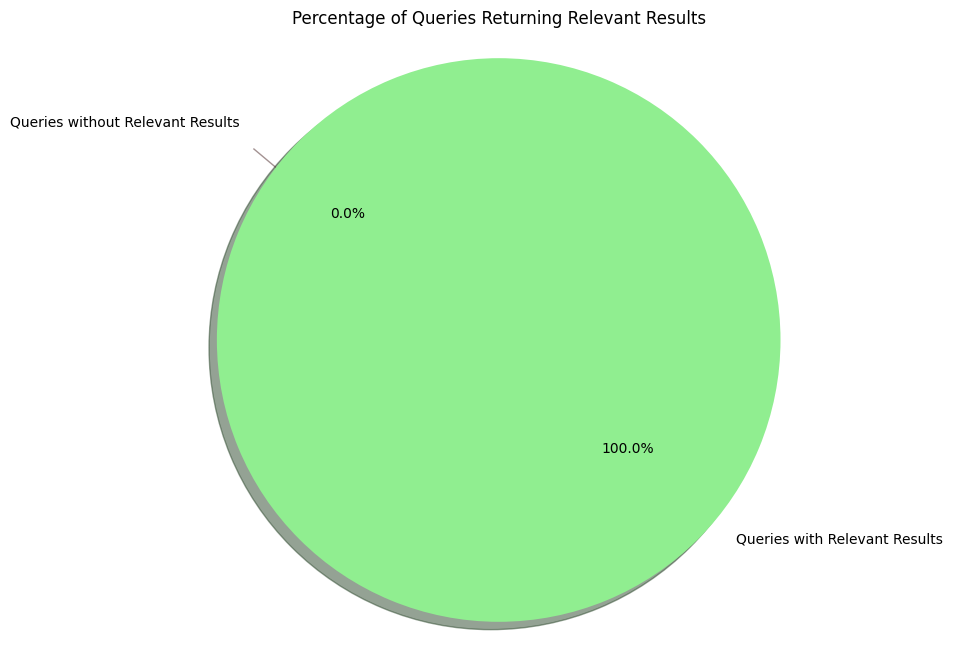

In [ ]:
# @title Evaluating RAG Performance: Relevant Results

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'complete_data' is already loaded
# If not, uncomment and modify the following line to load your dataset
# complete_data = pd.read_csv('/path/to/complete_dataset_scored.csv')

# Identify unique queries
unique_queries = complete_data['Query'].unique()

# Initialize a counter for queries that returned relevant results
queries_with_relevant_results = 0

# Check if each query returned at least one relevant result
for query in unique_queries:
    query_data = complete_data[complete_data['Query'] == query]
    if query_data['Scored_Relevance'].sum() > 0:
        queries_with_relevant_results += 1

# Calculate the percentage of queries with relevant results
total_queries = len(unique_queries)
relevant_query_percentage = (queries_with_relevant_results / total_queries) * 100

# Prepare data for the chart
labels = ['Queries with Relevant Results', 'Queries without Relevant Results']
sizes = [relevant_query_percentage, 100 - relevant_query_percentage]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'Queries with Relevant Results')

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Percentage of Queries Returning Relevant Results')
plt.show()


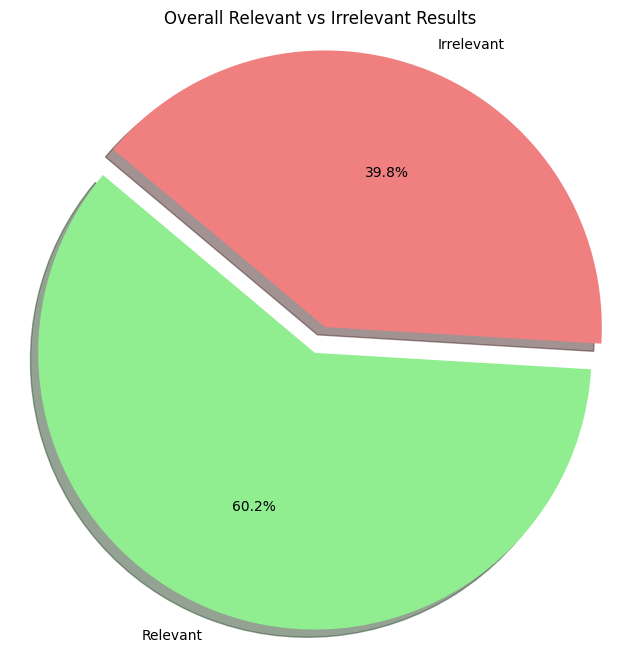

In [ ]:
# @title Evaluating RAG Performance: Relevant vs Irrelevant Results - 3.3

# Calculate the performance of each model for finding relevant results
bm25_relevant_performance = ((complete_data['BM25 Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() / complete_data['BM25 Score'].notna().sum() * 100
semantic_relevant_performance = ((complete_data['Semantic Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() / complete_data['Semantic Score'].notna().sum() * 100
colbert_relevant_performance = ((complete_data['ColBERT Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() / complete_data['ColBERT Score'].notna().sum() * 100

# Calculate the number of irrelevant results for each model
bm25_irrelevant = complete_data['BM25 Score'].notna().sum() - ((complete_data['BM25 Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()
semantic_irrelevant = complete_data['Semantic Score'].notna().sum() - ((complete_data['Semantic Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()
colbert_irrelevant = complete_data['ColBERT Score'].notna().sum() - ((complete_data['ColBERT Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()

# Calculate overall relevant and irrelevant counts
total_relevant = ((complete_data['BM25 Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() + \
                 ((complete_data['Semantic Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() + \
                 ((complete_data['ColBERT Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()
total_irrelevant = len(complete_data) - total_relevant

labels = 'Relevant', 'Irrelevant'
sizes = [total_relevant, total_irrelevant]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'Relevant')

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Overall Relevant vs Irrelevant Results')
plt.show()

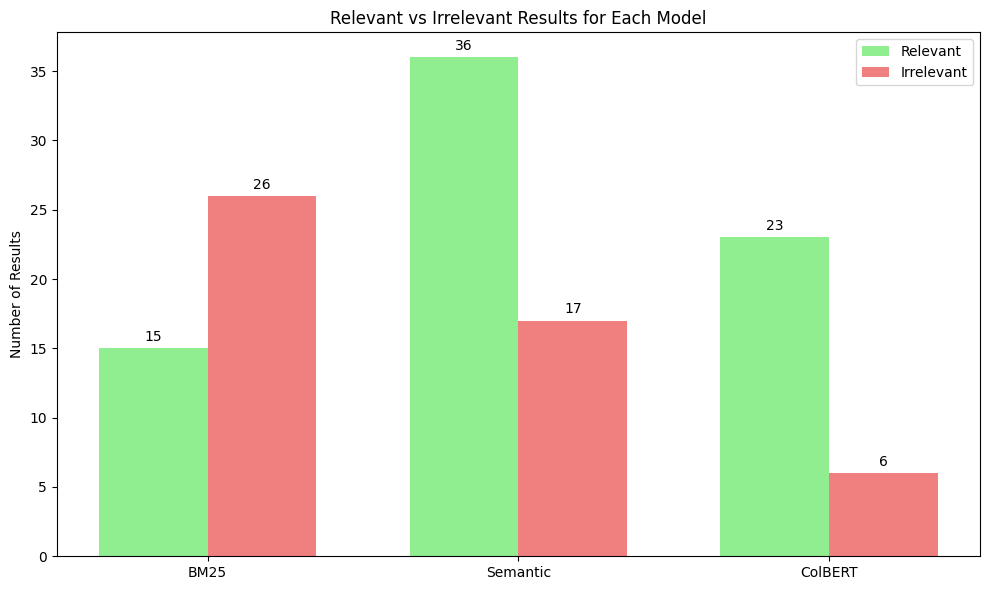

In [ ]:
# @title Evaluating RAG Performance: Relevancy by Model

import numpy as np

# Calculate the number of relevant results for each model
bm25_relevant = ((complete_data['BM25 Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()
semantic_relevant = ((complete_data['Semantic Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()
colbert_relevant = ((complete_data['ColBERT Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()

# Calculate the number of irrelevant results for each model
bm25_irrelevant = complete_data['BM25 Score'].notna().sum() - bm25_relevant
semantic_irrelevant = complete_data['Semantic Score'].notna().sum() - semantic_relevant
colbert_irrelevant = complete_data['ColBERT Score'].notna().sum() - colbert_relevant


# Data preparation
labels = ['BM25', 'Semantic', 'ColBERT']
relevant_counts = np.array([bm25_relevant, semantic_relevant, colbert_relevant])
irrelevant_counts = np.array([bm25_irrelevant, semantic_irrelevant, colbert_irrelevant])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, relevant_counts, width, label='Relevant', color='lightgreen')
rects2 = ax.bar(x + width/2, irrelevant_counts, width, label='Irrelevant', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Results')
ax.set_title('Relevant vs Irrelevant Results for Each Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add bar labels
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

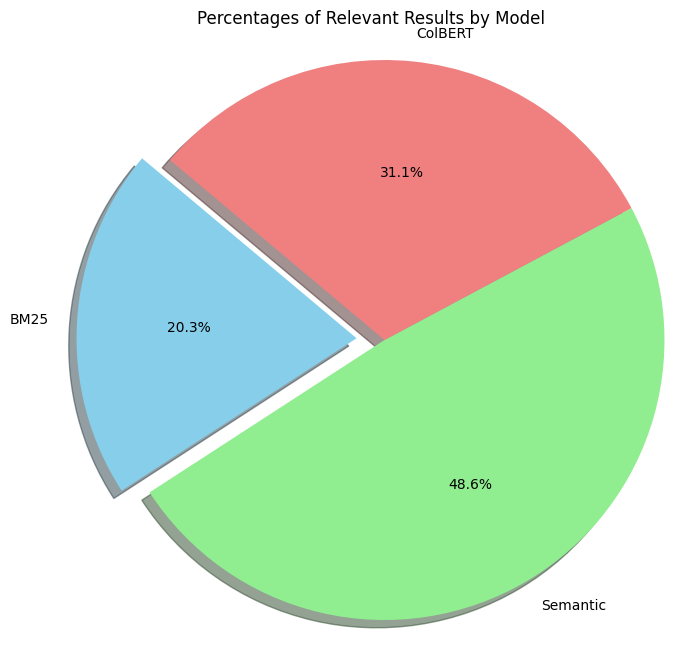

In [ ]:
# @title Evaluating RAG Performance: Relevant Results by Model

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'complete_data' is already loaded
# If not, uncomment and modify the following line to load your dataset
# complete_data = pd.read_csv('/path/to/complete_dataset_scored.csv')

# Calculate the number of relevant results for each model
bm25_relevant = ((complete_data['BM25 Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()
semantic_relevant = ((complete_data['Semantic Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()
colbert_relevant = ((complete_data['ColBERT Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum()

# Calculate the total number of relevant results
total_relevant = bm25_relevant + semantic_relevant + colbert_relevant

# Calculate the percentages of relevant results by model
bm25_relevant_percentage = (bm25_relevant / total_relevant) * 100
semantic_relevant_percentage = (semantic_relevant / total_relevant) * 100
colbert_relevant_percentage = (colbert_relevant / total_relevant) * 100

# Prepare the data for the pie chart
labels = ['BM25', 'Semantic', 'ColBERT']
sizes = [bm25_relevant_percentage, semantic_relevant_percentage, colbert_relevant_percentage]
colors = ['skyblue', 'lightgreen', 'lightcoral']
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e. 'BM25')

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Percentages of Relevant Results by Model')
plt.show()


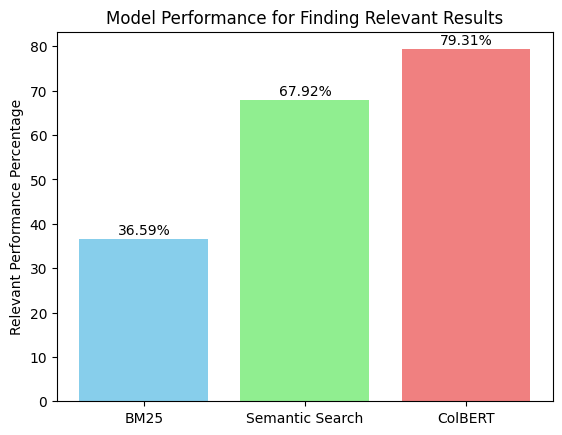

In [ ]:
# @title Evaluating RAG Performance: Model Performance on Relevant Results

# Recalculate the model performance scores based on the revised understanding of determining relevance
bm25_relevant_performance = ((complete_data['BM25 Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() / complete_data['BM25 Score'].notna().sum() * 100
semantic_relevant_performance = ((complete_data['Semantic Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() / complete_data['Semantic Score'].notna().sum() * 100
colbert_relevant_performance = ((complete_data['ColBERT Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() / complete_data['ColBERT Score'].notna().sum() * 100

# Recalculate overall relevant performance
overall_relevant_performance = ((complete_data['BM25 Score'].notna() | complete_data['Semantic Score'].notna() | complete_data['ColBERT Score'].notna()) & (complete_data['Mistral Output'].str.contains("Relevant"))).sum() / len(complete_data) * 100

model_performance = {
    "BM25": bm25_relevant_performance,
    "Semantic Search": semantic_relevant_performance,
    "ColBERT": colbert_relevant_performance
    }

# Plotting the model performance
fig, ax = plt.subplots()
ax.bar(model_performance.keys(), model_performance.values(), color=['skyblue', 'lightgreen', 'lightcoral', 'lightblue'])
ax.set_ylabel('Relevant Performance Percentage')
ax.set_title('Model Performance for Finding Relevant Results')
for i, v in enumerate(model_performance.values()):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center')

# Display the plot
plt.show()

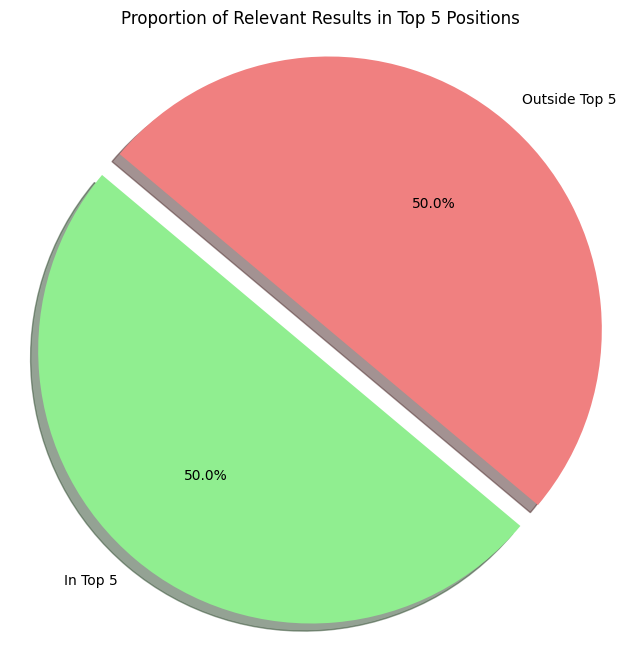

In [ ]:
# @title Evaluating RAG Performance: Relevant Results by Position

import matplotlib.pyplot as plt

# Filter relevant results
relevant_results = complete_data[complete_data['Scored_Relevance'] == 1]

# Extract relevant results and their reranking positions
relevant_positions = relevant_results['reranking_rank']

# Calculate the percentage of relevant results in top 5 positions
top_5_relevant = relevant_positions[relevant_positions <= 5].count()
total_relevant = relevant_positions.count()
percentage_top_5 = (top_5_relevant / total_relevant) * 100

# Calculate the counts for relevant results in and out of top 5 positions
in_top_5 = top_5_relevant
out_of_top_5 = total_relevant - top_5_relevant

# Pie chart for relevant results in top 5 positions vs. outside top 5
labels = ['In Top 5', 'Outside Top 5']
sizes = [in_top_5, out_of_top_5]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # only "explode" the 1st slice (i.e. 'In Top 5')

fig2, ax2 = plt.subplots(figsize=(8, 8))
ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Proportion of Relevant Results in Top 5 Positions')
plt.show()


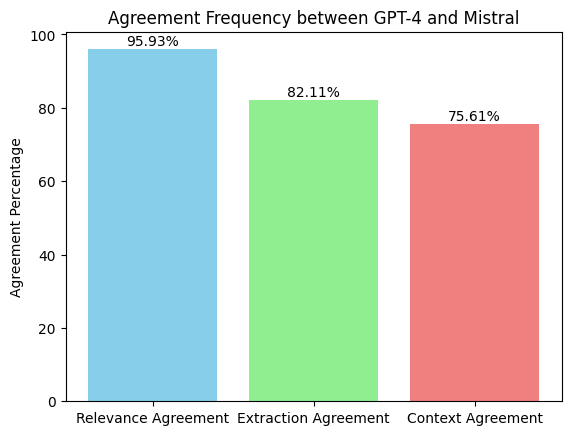

In [ ]:
# @title Evaluating RAG Performance: Agreement between Mistral & GPT-4 on Relevance Task

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate agreement frequency between GPT-4 and Mistral's outputs for the three categories
agreement_relevance = complete_data['Scored_Relevance'].mean() * 100
agreement_extraction = complete_data['Scored_Extraction'].mean() * 100
agreement_context = complete_data['Scored_Context'].mean() * 100

# Prepare the results
agreement_frequencies = {
    "Relevance Agreement": agreement_relevance,
    "Extraction Agreement": agreement_extraction,
    "Context Agreement": agreement_context,
}

# Agreement Frequency Visualization
fig, ax = plt.subplots()
ax.bar(agreement_frequencies.keys(), agreement_frequencies.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
ax.set_ylabel('Agreement Percentage')
ax.set_title('Agreement Frequency between GPT-4 and Mistral')
for i, v in enumerate(agreement_frequencies.values()):
    ax.text(i, v + 1, f"{v:.2f}%", ha='center')

# Display the plot
plt.show()

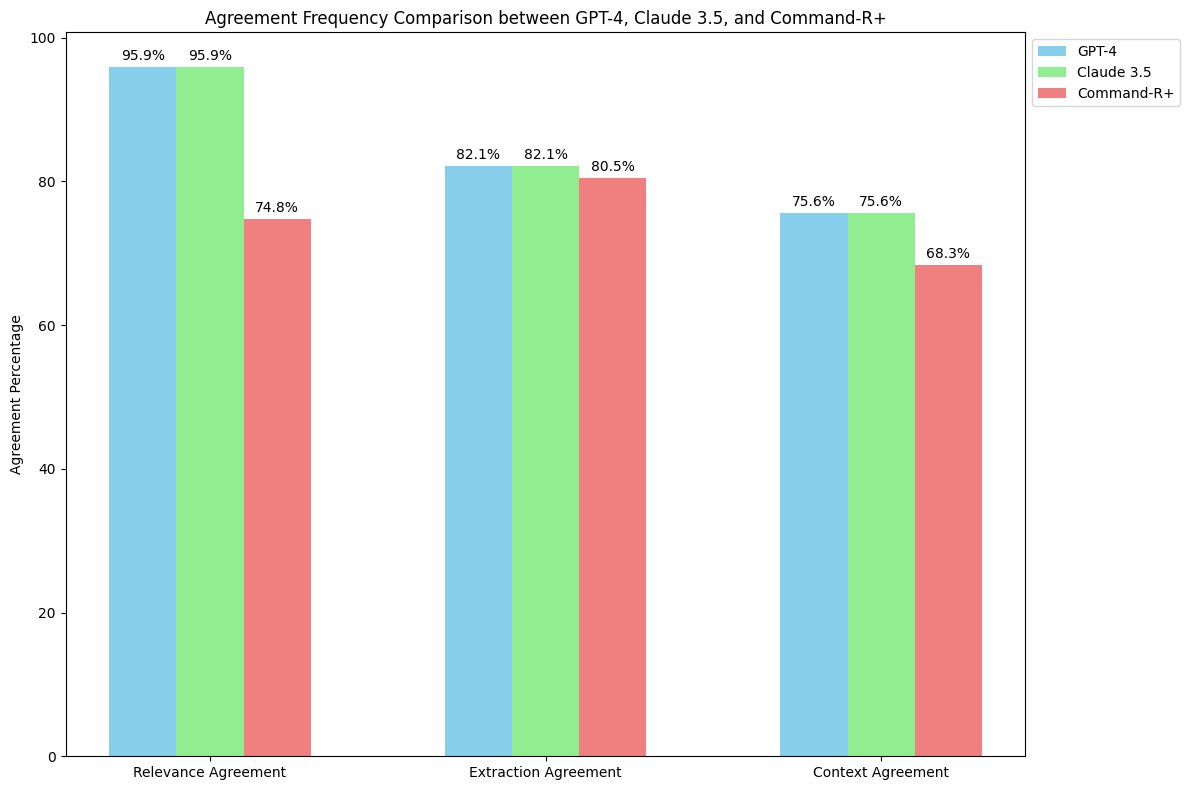

In [ ]:
# @title Evaluating RAG Performance: Overall LLM Agreement with Mistral on Relevance Task

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'complete_data_gpt4', 'complete_data_claude', and 'complete_data_commandr' are already loaded

# Calculate agreement rates for each model

def calculate_agreement_rates(data):
    relevance_agreement = data['Scored_Relevance'].mean() * 100
    extraction_agreement = data['Scored_Extraction'].mean() * 100
    context_agreement = data['Scored_Context'].mean() * 100
    return relevance_agreement, extraction_agreement, context_agreement

# Agreement rates for GPT-4
agreement_relevance_gpt4, agreement_extraction_gpt4, agreement_context_gpt4 = calculate_agreement_rates(complete_data)
agreement_frequencies_gpt4 = {
    "Relevance Agreement": agreement_relevance_gpt4,
    "Extraction Agreement": agreement_extraction_gpt4,
    "Context Agreement": agreement_context_gpt4,
}

# Agreement rates for Claude 3.5
agreement_relevance_claude, agreement_extraction_claude, agreement_context_claude = calculate_agreement_rates(complete_data_claude)
agreement_frequencies_claude = {
    "Relevance Agreement": agreement_relevance_claude,
    "Extraction Agreement": agreement_extraction_claude,
    "Context Agreement": agreement_context_claude,
}

# Agreement rates for Command-R+
agreement_relevance_commandr, agreement_extraction_commandr, agreement_context_commandr = calculate_agreement_rates(complete_data_commandr)
agreement_frequencies_commandr = {
    "Relevance Agreement": agreement_relevance_commandr,
    "Extraction Agreement": agreement_extraction_commandr,
    "Context Agreement": agreement_context_commandr,
}

# Visualize the different rates for the three models
labels = ['Relevance Agreement', 'Extraction Agreement', 'Context Agreement']
gpt4_values = list(agreement_frequencies_gpt4.values())
claude_values = list(agreement_frequencies_claude.values())
commandr_values = list(agreement_frequencies_commandr.values())

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width, gpt4_values, width, label='GPT-4', color='skyblue')
rects2 = ax.bar(x, claude_values, width, label='Claude 3.5', color='lightgreen')
rects3 = ax.bar(x + width, commandr_values, width, label='Command-R+', color='lightcoral')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Agreement Percentage')
ax.set_title('Agreement Frequency Comparison between GPT-4, Claude 3.5, and Command-R+')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add bar labels with only one decimal place
for rect in rects1 + rects2 + rects3:
    height = rect.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()


There are other evaluation metrics that can be employed to examine the effeciveness of a RAG pipeline. Methods like [BERTScore](https://github.com/Tiiiger/bert_score) and specialized RAG evaluation approaches like [ARES](https://github.com/stanford-futuredata/ARES) and [RAGAS](https://github.com/explodinggradients/ragas) offer additional insights into the quality of RAG summaries, and how to improve them. Frameworks like [Langchain](https://docs.smith.langchain.com/old/cookbook/testing-examples) now offer a host of automated evaluation pipelines for a variety of performance areas. And of course, scholars should consider their own training and expertise in devising judgements of RAG's place in the historian's toolkit.

